In [1]:
#今為ResNet50示範 heatmap辨識位置(標示CNN學習位置,多用於事後檢驗)

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#今為ResNet50 就要按ResNet50影像前處理方式preprocess_input(pretrain model亦同:用哪種方式分析影像就要用其前處理)
#有的影像分析是直接normalization 0~1 或 -1~1, 有的是扣除平均值再normalization
import os

import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from matplotlib import pyplot as plt
import numpy as np
import random

import keras
from glob import glob
from tqdm.auto import tqdm
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


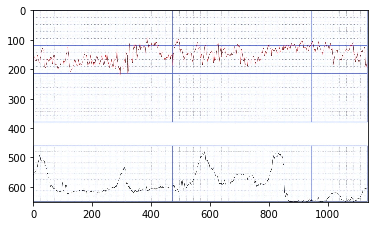

In [3]:
data_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/*/*.jpg'  
img_path = glob(data_path)
img = cv2.imread(img_path[0])
plt.imshow(img)

In [0]:
def processing_image(img_path):
    img = cv2.imread(img_path)[:,:,::-1]  
    # img = cv2.imread(os.path.join(data_path, 'NG_0222full_6832129-11.jpg'))[:,:,::-1]  
    img = cv2.resize(img, (299,299))
    x = np.expand_dims(img, axis=0)
    
    # 影像前處理: 將 RBG 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)
    return x

In [0]:
#gradcam模型: 吃一個模型然後吃一張圖,今用的是在imagenet已訓練好的ResNet50
def gradcam(model, x):                                                          
    # 取得影像的分類類別:先讓model進行預測,得最高機率的分類類別
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])

    # 取得影像分類名稱:以imagenet_utils(有分1000類別)把預測結果給decode出來,給出類別名字
    #pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    pred_class_name = keras.utils.to_categorical(preds, num_classes=2)

    # 預測分類的輸出向量:秀出pretrain模型的分類名字與值
    pred_output = model.output[:, pred_class]                                   #把pred_class帶入pre-train好的模型

    # 最後一層 convolution layer 輸出的 feature map                               
    # 今為分析ResNet 的最後一層 convolution layer                                 #(最(後)深一層有較多資訊[視野最廣,看的是整張圖,才能反推辨識focus[高階/抽象特徵]) [淺層:看的是線條與顏色, batch_normalization層:看的是Conv之後的平均值]
  ##last_conv_layer = model.get_layer('res5c_branch2c')                         #@(今取ResNet50的Conv最後一層)[日後可指定自己模型的層名]
    last_conv_layer = model.get_layer('mixed10')

    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]                 #pred_output代表最終預測的物件[反推:feature map要怎調動 會得最大數值(最大代表秀出focus位置(grads))]
                                                                                #K為Keras縮寫,內建backend(提供底層操作(以前拿來抽替變更用),backend預設為tensorflow所屬)有求梯度的func
    # 求得針對每個 feature map 的梯度加總: 今K為Keras內建底層tensorflow
    pooled_grads = K.sum(grads, axis=(0, 1, 2))                                 #grads加總

    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])   #藉由[model.input], [pooled_grads, last_conv_layer.output[0]反推filter

    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])                  #[x]就是最初input影像,匯入,得pooled_grads_value, conv_layer_output_value

    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性    #把每層feature map乘以權重(activation_func的值)再進行疊加:講義GAP
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
    # 計算 feature map 的 channel-wise 加總                                      #加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)

    return heatmap, pred_class_name


In [0]:
def plot_heatmap(heatmap, img_path, pred_class_name):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像                                                                   #影像經activation_func, normalization,再疊加在原始影像上
    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()
    
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))

    # 拉伸 heatmap
    print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.title(pred_class_name)
    
    plt.show()

In [7]:
##model = ResNet50(weights='imagenet')                                            #@這邊也可以直接load自己的model,匯入的同時就匯入該model參數
#model.summary()                                                                #@由這邊得知model指定的層名(位於最後一層的Conv2D(shape為7*7*2048)之後接Batch_normalization,GAP)

model = load_model(os.path.join(data_path, '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/HC-IncepV3-1-val_loss0.019-val_acc0.98.h5'))
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [8]:
img_path = '/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/fullOK/OK_demo0124full_60549600-8-007.jpg'      #@匯入圖路徑
# img_path = img_path[0]
img_path
# OK_demo0124full_58750969-0.jpg

'/content/drive/My Drive/Colab Notebooks/tjp_HC_models/tjp_imgs for model training(199imgs)/fullOK/OK_demo0124full_60549600-8-007.jpg'

In [9]:
cls = img_path.split('/')[-2]
cls

'fullOK'

(8, 8)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


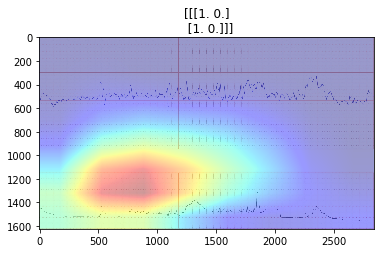

In [10]:
img = processing_image(img_path)                                                #把圖讀出來

# heatmap, pred_class_name = gradcam(model, img)                                  #@把model, img丟入gradcam_func, 得heatmap與類別名稱[這邊的model可以置換成各類模型,不侷限於分類模型]
heatmap, cls = gradcam(model, img)                                                                                #也可置換img
# plot_heatmap(heatmap, img_path, pred_class_name)                                #丟入畫熱圖_func
plot_heatmap(heatmap, img_path, cls)
#結果解述:若熱點標錯位,就去除該所在區域(目前沒有"指定辨識位置"的func)

#@可以自己換模型.換層名再以此模run